# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.10KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

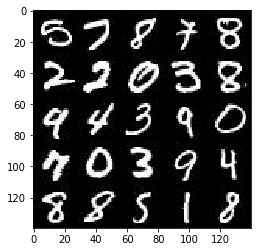

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

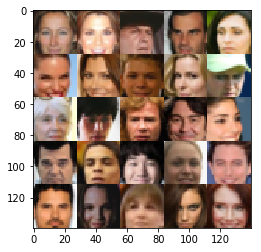

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    realInput    = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels),name="input_real")
    zData        = tf.placeholder(tf.float32, shape=(None,z_dim),name="input_z")
    learningRate = tf.placeholder(tf.float32, shape=(),name="lr")

    return realInput, zData, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel = 5
        stride = 2
        alpha  = 0.2
        prob   = 0.93
        
        a = tf.layers.conv2d(images, 64, kernel, strides = stride, padding='same',activation=None)
        a = tf.layers.batch_normalization(a, training=True)
        a = tf.maximum(alpha * a, a) 

        b = tf.layers.conv2d(a, 128, kernel, strides = stride, padding='same',activation=None)
        b = tf.layers.batch_normalization(b, training=True)
        b = tf.nn.dropout(b, keep_prob=prob)
        b = tf.maximum(alpha * b, b) 

        c = tf.layers.conv2d(b, 256, kernel, strides = stride, padding='same',activation=None)
        c = tf.layers.batch_normalization(c, training=True)
#        c = tf.nn.dropout(c, keep_prob=prob)
        c = tf.maximum(alpha * c, c) 

        flat   = tf.reshape(c,(-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.nn.dropout(logits,keep_prob=prob)
        out    = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def conv2dTranspose( inp, size, kernel,stride):
    return tf.layers.conv2d_transpose(inp, size, kernel, strides=stride, 
                                      padding ='same', activation=None,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    prob  = 0.9
    alpha = 0.18
    with tf.variable_scope('generator', reuse=reuse):    
        
        a = tf.layers.dense(z, 7*7*512)
        a = tf.reshape(a, (-1, 7, 7, 512))
        a = tf.layers.batch_normalization(a, training = is_train)
        a = tf.maximum(alpha*a, a)
        
        b = conv2dTranspose(a, 256, 5, 2)
        b = tf.layers.batch_normalization(b, training = is_train)
        b  = tf.nn.dropout(b, keep_prob=prob)
        b = tf.maximum(alpha*b, b)

        c = conv2dTranspose(b, 128, 5 ,2)
        c = tf.layers.batch_normalization(c, training = is_train)
        c  = tf.nn.dropout(c, keep_prob=prob)
        c = tf.maximum(alpha*c, c)


        logits = conv2dTranspose(c, out_channel_dim, 3, 1)
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


## Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    gModel                  = generator(input_z, out_channel_dim, is_train=True)
    dModelReal, dLogitsReal = discriminator(input_real, reuse=False)
    dModelFake, dLogitsFake = discriminator(gModel, reuse=True)
    
    dLossReal = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsReal, labels=tf.ones_like(dModelReal) * (1.0 - smooth)))
    dLossFake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsFake, labels=tf.zeros_like(dModelFake)))
    gLoss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dLogitsFake, labels=tf.ones_like(dModelFake)))

    dLoss = dLossReal + dLossFake 
    return dLoss, gLoss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    tVars = tf.trainable_variables()
    gVars = [var for var in tVars if var.name.startswith('generator')]
    dVars = [var for var in tVars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dTrainOpt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dVars)
        gTrainOpt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gVars)
    
    return dTrainOpt, gTrainOpt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputReal, inputZ, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dLoss, gLoss          = model_loss(inputReal, inputZ, data_shape[3])
    dTrainOpt, gTrainOpt  = model_opt(dLoss, gLoss, lr, beta1)
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print(data_shape[3])
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images *= 2.0
                batchZ = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                #No clue what underscores mean... took it from GAN Lesson 1/16
                _ = sess.run(dTrainOpt, feed_dict={ inputReal: batch_images, inputZ: batchZ, lr: learning_rate })
                _ = sess.run(gTrainOpt, feed_dict={ inputReal: batch_images, inputZ: batchZ, lr: learning_rate })

                if i == 0:
                    show_generator_output(sess, 25, inputZ, data_shape[3], data_image_mode)

                
                if (i%20) == 0:
                        #Took print function from GAN Lesson 1/16
                        trainLossD = dLoss.eval({inputReal: batch_images, inputZ: batchZ})
                        trainLossG = gLoss.eval({inputZ: batchZ})
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(trainLossD),
                              "Generator Loss: {:.4f}".format(trainLossG)) 
        
                if (i%100) == 0:
                        show_generator_output(sess, 25, inputZ, data_shape[3], data_image_mode)
                        print(i)
                i +=1 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

128
1


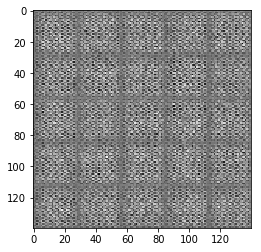

Epoch 1/2... Discriminator Loss: 3.8194... Generator Loss: 0.1039


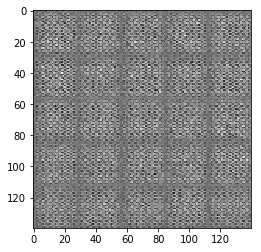

0
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 3.2478
Epoch 1/2... Discriminator Loss: 2.1239... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.9520... Generator Loss: 3.4124
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.9692


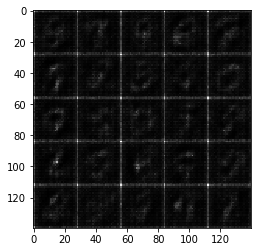

100
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 1.3654
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.6355


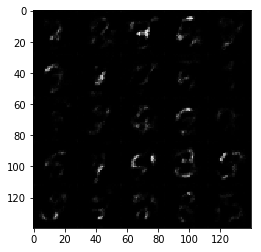

200
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.6196
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.1567
Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.4298
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 0.9834


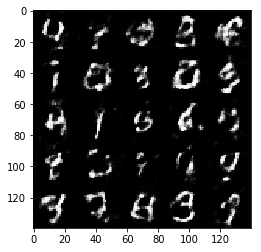

300
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.9624


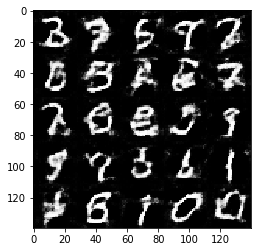

400
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.8122


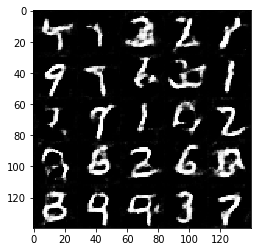

500
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 1.2079
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.0147


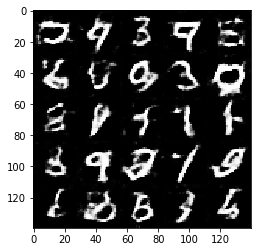

600
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 1.3902
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.2052


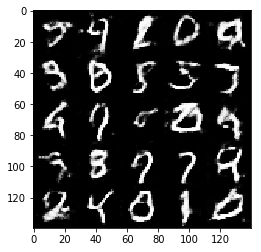

700
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.3789
Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.5482
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.6633


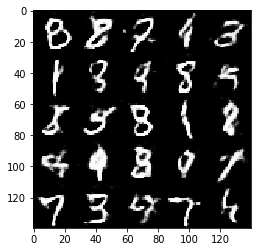

800
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 1.3554


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

3


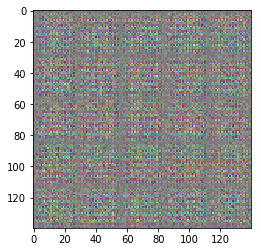

Epoch 1/1... Discriminator Loss: 3.3695... Generator Loss: 0.1456


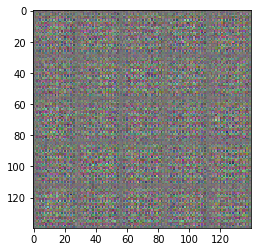

0
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 3.8788
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 5.1025
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.7003
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 4.4517
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 3.9322


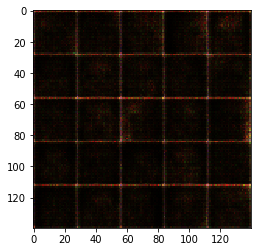

100
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 3.0844
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.5752


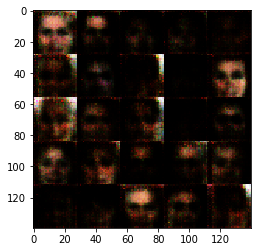

200
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 3.0533


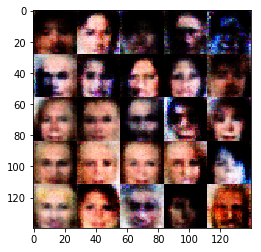

300
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 2.5727
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.3687


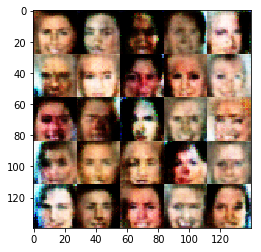

400
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.3596


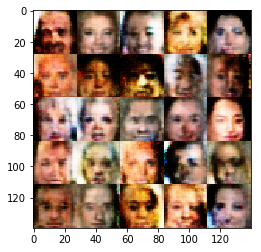

500
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.2423


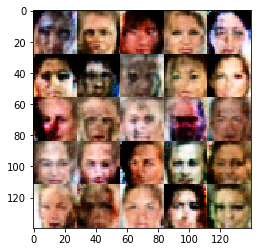

600
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.4274


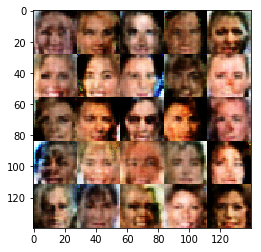

700
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 2.4446
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6008


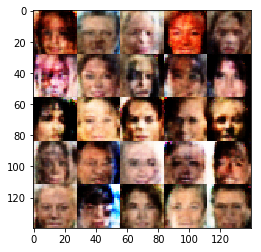

800
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.6574
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.2520


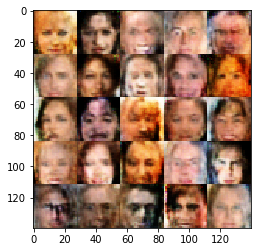

900
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.1501
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.1366


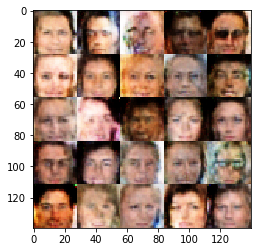

1000
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.0709


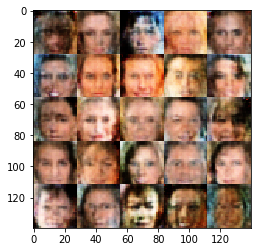

1100
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.3739


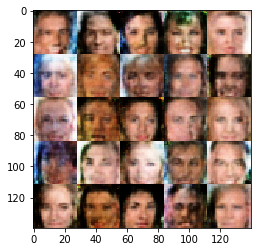

1200
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.6896


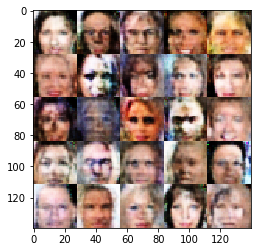

1300
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 1.5141


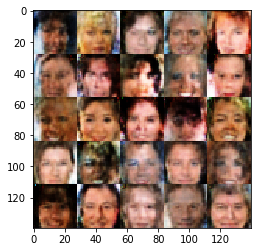

1400
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.3902
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9391


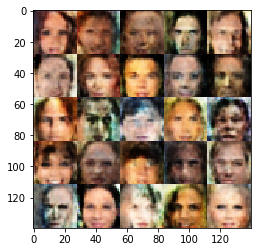

1500
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8320


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.